In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from cobra.flux_analysis import flux_variability_analysis
from matplotlib_venn import venn2
import seaborn as sns
import numpy as np

### loading excel with effect of drugs on proteins

In [2]:
InhibitProteinsDF=pd.read_excel("Btheta_2018AllOtherDrugsInhibit.xlsx", index_col=0)
InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")
print('species', list(InhibitProteinsDF.targetSpecies.unique()))
print('number of unique Prestwick IDs', len(list(InhibitProteinsDF.prestwickID.unique())))
print('number of unique STITCH IDs', len(list(InhibitProteinsDF.CIDno.unique())))
InhibitProteinsDF.head()

species ['human', 'not a drug', 'protozoa', 'viruses', 'bacteria', 'antiseptic', 'fungi', 'metazoan parasites', 'veterinary: infections', 'veterinary: metazoan parasites']
number of unique Prestwick IDs 242
number of unique STITCH IDs 232


/tmp/ipykernel_61/146863096.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")


,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
1068,BT_2047,WP_008761063_1,thymidylate synthase,NaN,Prestw-738,Folinic acid calcium salt,V03AF03 V03AF04 V03AF06,human,143,CIDm00000143,690
483,BT_0555,WP_008765068_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,224,CIDm00000224,725
1827,BT_4582,WP_008764741_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,224,CIDm00000224,725
751,BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-440,Epiandrosterone,A14AA,human,225,CIDm00000225,564
752,BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-697,3-alpha-Hydroxy-5-beta-androstan-17-one,A14AA,human,225,CIDm00000225,564


## Knock-out effect of each drug

In [3]:
DrugsNamesDF=InhibitProteinsDF.copy()
DrugsNamesDF=DrugsNamesDF[['DrugName','prestwickID']]
DrugsNamesDF.drop_duplicates(inplace=True)

# print(DrugsNamesDF)

UniqueDrugsIdsList=DrugsNamesDF['prestwickID'].unique().tolist()

# UniqueDrugsIdsList
# print(UniqueDrugsIdsList)

ProteinsNamesDF=InhibitProteinsDF.copy()
ProteinsNamesDF=ProteinsNamesDF[['STITCHid','CarveMeID', 'ProteinName', 'symbol']]
ProteinsNamesDF.drop_duplicates(inplace=True)
# print(ProteinsNamesDF)

### proteins in stitch vs model

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


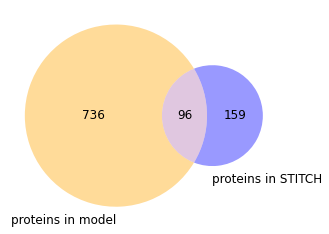

In [4]:
proteinsSTITCH=list(InhibitProteinsDF.CarveMeID.unique())
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
proteinsModel=[]
for x in Model.genes:
    proteinsModel.append(x.id)
Venn=venn2([set(proteinsModel), set(proteinsSTITCH)],set_labels=('proteins in model', 'proteins in STITCH'), set_colors=('orange', 'blue'))
for text in Venn.subset_labels:
    text.set_fontsize(12)

# <span style='color:red'> **CarveMe** </span> model

In [5]:
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
ObjValue_before=Model.optimize().objective_value
fluxBefore=flux_variability_analysis(Model)
fluxBefore=fluxBefore.round(0)
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    IP_Stitch=len(UniqueProteinIds)
    ProteinINmodel=[]
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    IP_Model=len(ProteinINmodel)
    if ProteinINmodel: #if list is not empty
        with Model as Model:
            cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
            ObjValue_after=Model.optimize().objective_value
            fluxAfter=flux_variability_analysis(Model)            
            fluxAfter=fluxAfter.round(0)
            fluxesCompare=fluxBefore.compare(fluxAfter) 
            TotalAffectedRxs=len(fluxesCompare)       
            percentFBAchange=abs(((ObjValue_after-ObjValue_before)/ObjValue_before)*100)
            percentFBAchange=round(percentFBAchange,0)
            DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model,TotalAffectedRxs, percentFBAchange]
            LB_data.append(DataRow)
    else:
        DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model, IP_Model, 0]
        LB_data.append(DataRow)

LB_df=pd.DataFrame(LB_data, columns=['drugId', 'drugName', 'StitchInhibtProteins', 'modelInhibtProteins','AffectedRxs', 'Growth%Change'])
LB_df=LB_df.set_index('drugId')
LB_df    

100%|██████████| 242/242 [12:09<00:00,  3.02s/it]


,drugName,StitchInhibtProteins,modelInhibtProteins,AffectedRxs,Growth%Change
drugId,,,,,
Prestw-738,Folinic acid calcium salt,1,1,0,0.0
Prestw-356,Adenosine 5'-monophosphate monohydrate,2,2,0,0.0
Prestw-440,Epiandrosterone,1,1,2,0.0
Prestw-697,3-alpha-Hydroxy-5-beta-androstan-17-one,1,1,2,0.0
Prestw-411,Androsterone,1,1,2,0.0
...,...,...,...,...,...
Prestw-525,Rifampicin,3,1,0,0.0
Prestw-1157,Rifapentine,3,1,0,0.0
Prestw-1233,Auranofin,3,3,16,0.0


In [ ]:
# LB_df.to_excel('allOtherDrugs_carveme.xlsx')

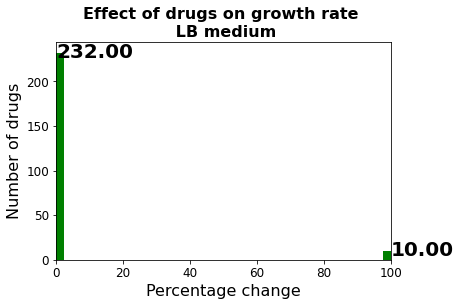

In [9]:
# LBpercentDF=concatDF.copy().round(0)
LBpercentDF=LB_df.copy().round(0)
LBpercentDF=LBpercentDF[["Growth%Change"]]
LBpercentDF=pd.DataFrame(LBpercentDF['Growth%Change'].value_counts())
LBpercentDF.index.names = ['change']
LBpercentDF=LBpercentDF.reset_index()
percentVal=LBpercentDF["change"].tolist()
count=LBpercentDF["Growth%Change"].tolist()
# plt.figure(figsize = (6,4))
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5, color="green")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of drugs on growth rate \n LB medium',fontsize=16, fontweight='bold')
plt.xlabel('Percentage change',fontsize=16)
plt.ylabel('Number of drugs',fontsize=16)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=20, fontweight='bold', xytext=(0, 10),
                   textcoords='offset points')
    
# plt.savefig('neuroDrugs_carveme_graphs_lb.png', bbox_inches="tight")

# CURATED

In [6]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    ObjValue_before=Model.optimize().objective_value
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)

    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        IP_Stitch=len(UniqueProteinIds)
        ProteinINmodel=[]
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        IP_Model=len(ProteinINmodel)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                ObjValue_after=Model.optimize().objective_value
                fluxAfter=flux_variability_analysis(Model)            
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) 
                TotalAffectedRxs=len(fluxesCompare)  
                percentFBAchange=abs(((ObjValue_after-ObjValue_before)/ObjValue_before)*100)
                percentFBAchange=round(percentFBAchange,0)
                DataRow=[drugId, IP_Model,TotalAffectedRxs, percentFBAchange]
                LB_data.append(DataRow)
        else:
            DataRow=[drugId, IP_Model, IP_Model, 0]
            LB_data.append(DataRow)

    LB_CURATED_df=pd.DataFrame(LB_data, columns=['drugId', 'CURATEDInhibtProteins','CURATEDAffectedRxs', 'CURATEDGrowth%Change'])
#     LB_CURATED_df=LB_CURATED_df.set_index('drugId')
    LB_CURATED_df

100%|██████████| 242/242 [06:48<00:00,  1.69s/it]


In [33]:
# LB_CURATED_df.to_excel('allOtherDrugs_curated.xlsx')

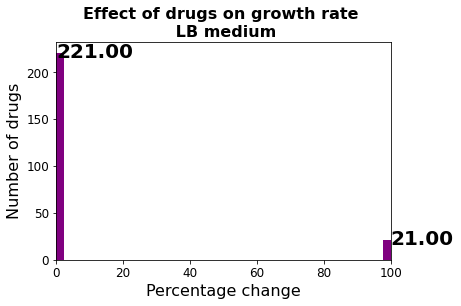

In [5]:
# LBpercentDF=concatDF.copy().round(0)
LBpercentDF=LB_CURATED_df.copy().round(0)
LBpercentDF=LBpercentDF[["CURATEDGrowth%Change"]]
LBpercentDF=pd.DataFrame(LBpercentDF['CURATEDGrowth%Change'].value_counts())
LBpercentDF.index.names = ['change']
LBpercentDF=LBpercentDF.reset_index()
percentVal=LBpercentDF["change"].tolist()
count=LBpercentDF["CURATEDGrowth%Change"].tolist()
# plt.figure(figsize = (6,4))
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5, color="purple")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of drugs on growth rate \n LB medium',fontsize=16, fontweight='bold')
plt.xlabel('Percentage change',fontsize=16)
plt.ylabel('Number of drugs',fontsize=16)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=20, fontweight='bold', xytext=(0, 10),
                   textcoords='offset points')
    
# plt.savefig('neuroDrugs_carveme_graphs_lb.png', bbox_inches="tight")

## Drugs that have STITCH info. and p-value<=0.01(i.e., had effect on bacterium's growth)

In [4]:
AllDrugs=pd.read_excel('2018DrugsCIDs.xlsx', header=0)
# AllDrugs

In [5]:
allOtherDrugsInfo=pd.read_excel('MaierEtAl2018_AllOtherDrugs.xlsx', index_col=0 )
allOtherDrugsInfo['CIDno'] = allOtherDrugsInfo['CID'].str.replace("CIDs", '')
print(len(list(allOtherDrugsInfo.CIDno.unique())))
# allOtherDrugsInfo

984


In [6]:
s3Info=pd.read_excel('S3_reduced.xlsx')
s3Info.rename(columns = {'prestwick_ID':'prestwickID'}, inplace = True)
cid=AllDrugs[["prestwickID", 'CID']]
s3Info = s3Info.merge(cid,how='left')
# print(len(list(s3Info.CID.unique())))
# s3Info

In [7]:
AllOtherDrugs_Prest=list(allOtherDrugsInfo.prestwickID.unique())
AllOtherDrugs_s3Info=s3Info[s3Info['prestwickID'].isin(AllOtherDrugs_Prest)]
signifPaper = AllOtherDrugs_s3Info[AllOtherDrugs_s3Info['Bacteroides thetaiotaomicron (NT5004)'] > 0.01]
print('number of drugs STITCH IDs that had effect on growth in vitro:', len(list(signifPaper.CID.unique())))

number of drugs STITCH IDs that had effect on growth in vitro: 876


In [8]:
NeuroPrest=list(InhibitProteinsDF.prestwickID.unique())
Neuros3Info=s3Info.copy()
Neuros3Info=s3Info[s3Info['prestwickID'].isin(NeuroPrest)]
# Neuros3Info

In [9]:
lastCol=Neuros3Info.columns[-2]
signifNeuroPaper = Neuros3Info[Neuros3Info[lastCol] <= 0.01]
# signifNeuroPaper
print('number of drugs Prest that had effect on growth in vitro:', len(list(signifNeuroPaper.prestwickID)))

cid=AllDrugs[["prestwickID", 'CID']]
signifNeuroPaper = signifNeuroPaper.merge(cid,how='left')
print('number of drugs Prest that had effect on growth in vitro:', len(list(signifNeuroPaper.CID.unique())))
# signifNeuroPaper
#none of these drugs correspond to prestwick ids with equal STITCH IDs

number of drugs Prest that had effect on growth in vitro: 41
number of drugs Prest that had effect on growth in vitro: 41


In [10]:
lastCol=Neuros3Info.columns[-2]
signifPaper = Neuros3Info[Neuros3Info[lastCol] > 0.01]
# signifNeuroPaper
print('number of drugs that had effect on growth in vitro:', len(list(signifPaper.prestwickID.unique())))
cid=AllDrugs[["prestwickID", 'CID']]
signifPaper = signifPaper.merge(cid,how='left')
print('number of drugs that had effect on growth in vitro:', len(list(signifPaper.CID.unique())))
# signifPaper
# signifNeuroPaper
#none of these drugs correspond to prestwick ids with equal STITCH IDs

number of drugs that had effect on growth in vitro: 200
number of drugs that had effect on growth in vitro: 190


In [14]:
test_list = list(Neuros3Info.prestwickID.unique())
 
# initializing remove list
remove_list = list(signifNeuroPaper.prestwickID.unique())+list(signifPaper.prestwickID.unique())
 
# using list comprehension to perform task
res = [i for i in test_list if i not in remove_list]
# res

In [11]:
LB_df=pd.read_excel('allOtherDrugs_carveme.xlsx', header=0, index_col=0)
LB_CURATED_df=pd.read_excel('allOtherDrugs_curated.xlsx', header=0, index_col=0)

# drugs that have an effect in vitro OR in silico

In [12]:
LBdfNpvalue=LB_df.copy().round(0)
LBdfNpvalue=LBdfNpvalue.reset_index()
LBdfNpvalue = LBdfNpvalue.merge(LB_CURATED_df,how='left')
LBdfNpvalue.rename(columns = {'drugId':'prestwickID'}, inplace = True)
lastCol=s3Info.columns[-2]
pvalue=s3Info[["prestwickID", lastCol]]
# print(pvalue)
cid=InhibitProteinsDF[["prestwickID",'targetSpecies', 'CIDno']]
cid=cid.drop_duplicates()
LBdfNpvalue = LBdfNpvalue.merge(pvalue,how='left')
LBdfNpvalue=LBdfNpvalue.merge(cid,how='left')
# pValueInfo = pValueInfo.merge(therapIndicDF,how='left')
# LBdfNpvalue

In [13]:
# LBdfNpvalue = LBdfNpvalue[(LBdfNpvalue['Growth%Change'] == 100.0) | (LBdfNpvalue['CURATEDGrowth%Change'] == 100.0) | (LBdfNpvalue[lastCol] <= 0.01) ]
# LBdfNpvalue = LBdfNpvalue[(LBdfNpvalue['Growth%Change'] == 100.0) | (LBdfNpvalue['CURATEDGrowth%Change'] >=90) | (LBdfNpvalue[lastCol] <= 0.01) ]
# LBdfNpvalue = LBdfNpvalue[(LBdfNpvalue['Growth%Change'] == 100.0) | (LBdfNpvalue['CURATEDGrowth%Change'] >=90) & (LBdfNpvalue[lastCol] <= 0.01) ]
# LBdfNpvalue = LBdfNpvalue[(LBdfNpvalue['Growth%Change'] != 100.0) & (LBdfNpvalue['CURATEDGrowth%Change'] <90) & (LBdfNpvalue[lastCol] > 0.01) ]
# LBdfNpvalue = LBdfNpvalue[(LBdfNpvalue['Growth%Change'] == 100.0) | (LBdfNpvalue['CURATEDGrowth%Change'] >=90) ]

In [14]:
LBdfNpvalue=LBdfNpvalue.sort_values(by=['Growth%Change'])
# LBdfNpvalue

In [15]:
LBdfNpvalue=LBdfNpvalue.sort_values(by=[lastCol])
# LBdfNpvalue.to_excel('allDrugs_vitroNsilico.xlsx')

In [16]:
# LBdfNpvalue.to_excel('allDrugs_noEffectSilico.xlsx')

15


/tmp/ipykernel_61/4162073720.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.tril(np.ones_like(LBdfNpvalueCarveme.corr(), dtype=np.bool))


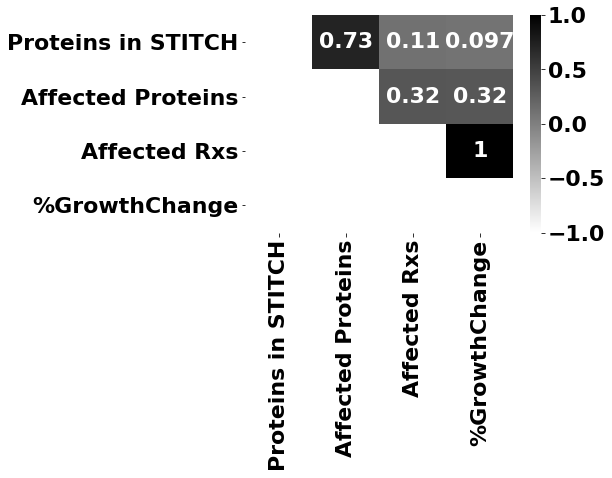

In [21]:
LBdfNpvalueCarveme=LBdfNpvalue.copy()
LBdfNpvalueCarveme=LBdfNpvalueCarveme[~LBdfNpvalueCarveme['prestwickID'].isin(intEssent)] #remove essential genes
# LBdfNpvalueCarveme = LBdfNpvalueCarveme[(LBdfNpvalueCarveme['Growth%Change'] == 100.0) & (LBdfNpvalueCarveme['CURATEDGrowth%Change'] >=90) ]
# LBdfNpvalueCarveme
LBdfNpvalueCarveme=LBdfNpvalueCarveme[['StitchInhibtProteins','modelInhibtProteins','AffectedRxs', 'Growth%Change' ]]
# LBdfNpvalueCarveme = LBdfNpvalueCarveme[(LBdfNpvalueCarveme['modelInhibtProteins']>1)] #to exclude essential genes
LBdfNpvalueCarveme.rename(columns={'StitchInhibtProteins': 'Proteins in STITCH',"modelInhibtProteins": "Affected Proteins",'AffectedRxs': "Affected Rxs", 'Growth%Change':'%GrowthChange'}, inplace=True)
# x=LBdfNpvalueCarveme.corr()
# x
# sns.heatmap(LBdfNpvalueCarveme.corr(), annot=True)

font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# mask = np.triu(np.ones_like(LBdfNpvalueCarveme.corr(), dtype=np.bool))
mask = np.tril(np.ones_like(LBdfNpvalueCarveme.corr(), dtype=np.bool))
heatmap = sns.heatmap(LBdfNpvalueCarveme.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=plt.get_cmap('binary'))
# heatmap = sns.heatmap(LBdfNpvalueCarveme.corr(), vmin=-1, vmax=1, annot=True, cmap=plt.get_cmap('binary'))

/tmp/ipykernel_19710/1613410849.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.tril(np.ones_like(LBdfNpvalueCurated.corr(), dtype=np.bool))


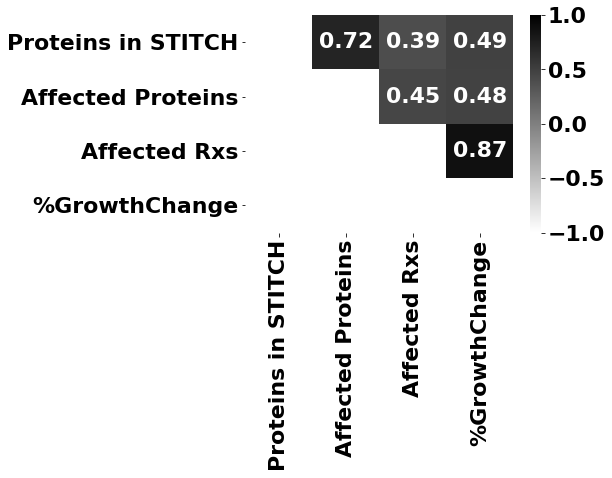

In [97]:
LBdfNpvalueCurated=LBdfNpvalue.copy()
LBdfNpvalueCurated=LBdfNpvalueCurated[~LBdfNpvalueCurated['prestwickID'].isin(intEssent)] #remove essential genes
LBdfNpvalueCurated=LBdfNpvalueCurated[['StitchInhibtProteins','CURATEDInhibtProteins','CURATEDAffectedRxs', 'CURATEDGrowth%Change' ]]
LBdfNpvalueCurated.rename(columns={'StitchInhibtProteins': 'Proteins in STITCH',"CURATEDInhibtProteins": "Affected Proteins",'CURATEDAffectedRxs': "Affected Rxs", 'CURATEDGrowth%Change':'%GrowthChange'}, inplace=True)

# x=LBdfNpvalueCurated.corr()
# x
# sns.heatmap(dataframe.corr(), annot=True)
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# mask = np.triu(np.ones_like(LBdfNpvalueCarveme.corr(), dtype=np.bool))
mask = np.tril(np.ones_like(LBdfNpvalueCurated.corr(), dtype=np.bool))
heatmap = sns.heatmap(LBdfNpvalueCurated.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=plt.get_cmap('binary'))
# heatmap = sns.heatmap(LBdfNpvalueCarveme.corr(), vmin=-1, vmax=1, annot=True, cmap=plt.get_cmap('binary'))

In [20]:
essentCarvePrest=sorted(essentCarvePrest)
essentCuratedPrest=sorted(essentCuratedPrest)
intEssent=set(essentCarvePrest+essentCuratedPrest)

In [57]:
# LBdfNpvalue.to_excel('allOtherDrugs_carvemeNcurated_94percent.xlsx')

In [13]:
# LBdfNpvalue.to_excel('allOtherDrugs_carvemeNcurated.xlsx')
lbAlldrugs=pd.read_excel('allOtherDrugs_carvemeNcurated.xlsx', header=0, index_col=0)
print(len(list(lbAlldrugs.prestwickID.unique())))
# lbAlldrugs

60


## info. about the drugs that had effect in vitro AND in silico

In [ ]:
EffectDrugs=lbAlldrugs.copy()
EffectDrugs=EffectDrugs.set_index('prestwickID')
pvalueCol=lbAlldrugs.columns[-3]
EffectDrugs=EffectDrugs[EffectDrugs[pvalueCol] <= 0.01]
# EffectDrugs
EffectDrugs=EffectDrugs[['Growth%Change', 'CURATEDGrowth%Change']]
indexList=[]
for index, row in EffectDrugs.iterrows():
    rowDF=EffectDrugs.loc[index]
    rowValues=row.values.tolist()
    res = any(val == 100.00 for val in rowValues)
    if res: #if p<0.05 for at least one cancer subtype 
        indexList.append(index)
print('number of drugs with effect on growth', len(indexList))
effectiveDrugs=InhibitProteinsDF[InhibitProteinsDF.prestwickID.isin(indexList)]
# effectiveDrugs.to_excel('allOtherDrugs_vitroANDsilico.xlsx')
# effectiveDrugs

### heatmap for proteins affected by drugs in vitro AND in silico

In [5]:
# dummy=effectiveDrugs.copy()
dummy=pd.read_excel('allOtherDrugs_vitroANDsilico_simplifiedNames.xlsx', header=0, index_col=0)
dummy=dummy[['prestwickID', 'ProteinName']]
dummy=pd.get_dummies(dummy, columns = ['ProteinName'], prefix = '')
dummy=dummy.set_index('prestwickID')
dummy=dummy.groupby(level=0).sum()
dummy.where(dummy <1, 1, inplace=True) #where value is <1, keep original value
dummy=dummy.drop(columns=['_hypothetical protein'])
dummy.loc['Total',:]= dummy.sum(axis=0)
dummy=dummy.sort_values(by=['Total'], axis=1)
dummy['Total']= dummy.sum(axis=1)
dummy=dummy.sort_values(by=['Total'], axis=0)
dummy=dummy.drop(columns=['Total'])
dummy=dummy.drop(index='Total')
dummy.columns = dummy.columns.str.replace("_", "")
dummy=dummy.T
dummy=dummy.sort_index(ascending=True)
# dummy

### separately for carveme and curated

In [6]:
# dummy=effectiveDrugs.copy()
dummy_carveme=pd.read_excel('allOtherDrugs_vitroANDsilico_simplifiedNames.xlsx', header=0, index_col=0)
LBmodel=read_sbml_model('Bthetaiotaomicron_gram_gapAfter_LB.xml.gz')
LBmodel.optimize()
allGenes=LBmodel.genes
essentGenesList=[]
for gene in allGenes:
    essentGenesList.append(gene.id)
essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
neuroGenes=set(list(InhibitProteinsDF.CarveMeID.unique())) #genes with interactions with neuro drugs
essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
dummy_carveme=dummy_carveme[dummy_carveme.CarveMeID.isin(essentNeuroGenes)] #drugs that interact with essential genes
dummy_carveme=dummy_carveme[['prestwickID', 'ProteinName']]
dummy_carveme=pd.get_dummies(dummy_carveme, columns = ['ProteinName'], prefix = '')
dummy_carveme=dummy_carveme.set_index('prestwickID')
dummy_carveme=dummy_carveme.groupby(level=0).sum()
# dummy_carveme.where(dummy_carveme <1, 1, inplace=True) #where value is <1, keep original value
# dummy_carveme=dummy_carveme.drop(columns=['_hypothetical protein'])
dummy_carveme.loc['Total',:]= dummy_carveme.sum(axis=0)
dummy_carveme=dummy_carveme.sort_values(by=['Total'], axis=1)
dummy_carveme['Total']= dummy_carveme.sum(axis=1)
dummy_carveme=dummy_carveme.sort_values(by=['Total'], axis=0)
dummy_carveme=dummy_carveme.drop(columns=['Total'])
dummy_carveme=dummy_carveme.drop(index='Total')
dummy_carveme.columns = dummy_carveme.columns.str.replace("_", "")
dummy_carveme=dummy_carveme.T
dummy_carveme=dummy_carveme.sort_index(ascending=True)
dummy_carveme = dummy_carveme[dummy.columns]
dummy_with_carveme=dummy.copy()
for col in dummy_with_carveme.columns:
    dummy_with_carveme[col].values[:] = 0
dummy_with_carveme.update(dummy_carveme)
# dummy_with_carveme

In [ ]:
plt.figure(figsize = (2,10))
# plt.title('Proteins in carveme with inhibiting interaction in STITCH')

# font = {'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)
# s=sns.heatmap(dummy_with_carveme, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = no protein interaction \n 1 = protein interaction', 'location': 'top'}, linewidths=0.01, linecolor='gray')
s=sns.heatmap(dummy_with_carveme,cmap="Blues", xticklabels=True, yticklabels=True,cbar_kws={'label': '0 = no protein interaction', 'location': 'top'}, linewidths=0.001, linecolor='gray',annot=True)
s.set(xlabel='Proteins', ylabel='Drugs')
# plt.savefig('BlackWhite_GramRxsDifferences.png')

In [ ]:
# dummy=effectiveDrugs.copy()
dummy_carveme=pd.read_excel('allOtherDrugs_vitroANDsilico_simplifiedNames.xlsx', header=0, index_col=0)

M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    allGenes=Model.genes
    essentGenesList=[]
    for gene in allGenes:
        essentGenesList.append(gene.id)
    essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
    neuroGenes=set(list(InhibitProteinsDF.STITCHid.unique())) #genes with interactions with neuro drugs
    essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
    dummy_carveme=dummy_carveme[dummy_carveme.STITCHid.isin(essentNeuroGenes)] #drugs that interact with essential genes
    dummy_carveme=dummy_carveme[['prestwickID', 'ProteinName']]
    dummy_carveme=pd.get_dummies(dummy_carveme, columns = ['ProteinName'], prefix = '')
    dummy_carveme=dummy_carveme.set_index('prestwickID')
    dummy_carveme=dummy_carveme.groupby(level=0).sum()
#     dummy_carveme.where(dummy_carveme <1, 1, inplace=True) #where value is <1, keep original value
    # dummy_carveme=dummy_carveme.drop(columns=['_hypothetical protein'])
    dummy_carveme.loc['Total',:]= dummy_carveme.sum(axis=0)
    dummy_carveme=dummy_carveme.sort_values(by=['Total'], axis=1)
    dummy_carveme['Total']= dummy_carveme.sum(axis=1)
    dummy_carveme=dummy_carveme.sort_values(by=['Total'], axis=0)
    dummy_carveme=dummy_carveme.drop(columns=['Total'])
    dummy_carveme=dummy_carveme.drop(index='Total')
    dummy_carveme.columns = dummy_carveme.columns.str.replace("_", "")
    dummy_carveme=dummy_carveme.T
    dummy_carveme=dummy_carveme.sort_index(ascending=True)
    dummy_carveme = dummy_carveme[dummy.columns]
    dummy_with_carveme=dummy.copy()
    for col in dummy_with_carveme.columns:
        dummy_with_carveme[col].values[:] = 0
    dummy_with_carveme.update(dummy_carveme)
    # dummy_with_carveme

In [ ]:
plt.figure(figsize = (2,10))
# plt.title('Proteins in carveme with inhibiting interaction in STITCH')

# font = {'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)

s=sns.heatmap(dummy_with_carveme, cmap="Blues", xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = no protein interaction', 'location': 'top'}, linewidths=0.001, linecolor='gray', annot=True)
s.set(xlabel='Proteins', ylabel='Drugs')
# plt.xticks(rotation=20)

# plt.savefig('BlackWhite_GramRxsDifferences.png')

## essential genes affected in CARVEME

In [18]:
LBmodel=read_sbml_model('Bthetaiotaomicron_gram_gapAfter_LB.xml.gz')
LBmodel.optimize()
essentGenes=cobra.flux_analysis.find_essential_genes(LBmodel, threshold=None, processes=None)
essentGenesList=[]
for gene in essentGenes:
    essentGenesList.append(gene.id)
if "spontaneous" in essentGenesList:
    essentGenesList.remove("spontaneous")
essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
# print(sorted(essentGenesList))
neuroGenes=set(list(InhibitProteinsDF.CarveMeID.unique())) #genes with interactions with neuro drugs
essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
essentRows=InhibitProteinsDF[InhibitProteinsDF.CarveMeID.isin(essentNeuroGenes)] #drugs that interact with essential genes
essentRows
essentCarvePrest=list(essentRows.prestwickID.unique())

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### essential genes affected in curated

In [19]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    essentGenes=cobra.flux_analysis.find_essential_genes(Model, threshold=None, processes=None)
    essentGenesList=[]
    for gene in essentGenes:
        essentGenesList.append(gene.id)
    if "spontaneous" in essentGenesList:
        essentGenesList.remove("spontaneous")
    essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
#     print(sorted(essentGenesList))
    neuroGenes=set(list(InhibitProteinsDF.STITCHid.unique())) #genes with interactions with neuro drugs
    essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
    essentRows=InhibitProteinsDF[InhibitProteinsDF.STITCHid.isin(essentNeuroGenes)] #drugs that interact with essential genes
    essentRows
    essentCuratedPrest=list(essentRows.prestwickID.unique())

In [31]:
essentRows

,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
1720,BT_3845,WP_008760772_1,IMP dehydrogenase,guaB,Prestw-741,Nadide,-,not a drug,925,CIDm00000925,832
1230,BT_2797,WP_055229256_1,adenosylhomocysteinase,ahcY,Prestw-741,Nadide,-,not a drug,925,CIDm00000925,618
1722,BT_3845,WP_008760772_1,IMP dehydrogenase,guaB,Prestw-94,Azathioprine,L04AX01,human,2265,CIDm00002265,588
89,BT_0347,WP_008766126_1,transketolase,NaN,Prestw-808,Furazolidone,G01AX06,bacteria,3435,CIDm00003435,604
754,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-1314,Pioglitazone,A10BG03,human,4829,CIDs00004829,388
100,BT_0382,WP_011107232_1,NAD-dependent epimerase/dehydratase family pro...,NaN,Prestw-1314,Pioglitazone,A10BG03,human,4829,CIDs00004829,388
91,BT_0373,WP_008760658_1,class I mannose-6-phosphate isomerase,NaN,Prestw-14,Sulfacetamide sodic hydrate,S01AB04,bacteria,5320,CIDm00005320,644
1111,BT_2123,WP_008759775_1,NAD(P)H-dependent glycerol-3-phosphate dehydro...,NaN,Prestw-256,Isotretinoin,D10AD01 D10AD04 D10BA01 D11AX19 L01XX14 L01XX22,human,5538,CIDm00005538,564
1112,BT_2123,WP_008759775_1,NAD(P)H-dependent glycerol-3-phosphate dehydro...,NaN,Prestw-257,Retinoic acid,D10AD01 D10AD04 D10BA01 D11AX19 L01XX14 L01XX22,human,5538,CIDm00005538,564
760,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-1479,Triclosan,D08AE04 D09AA06,antiseptic,5564,CIDs00005564,382


In [ ]:
# list(essentRows.ProteinName)

In [8]:
LBmodel=read_sbml_model('Bthetaiotaomicron_gram_gapAfter_LB.xml.gz')
LBmodel.optimize()
essentGenes=LBmodel.genes
essentGenesList=[]
for gene in essentGenes:
    essentGenesList.append(gene.id)
essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
curatedEssent=list(essentRows.CarveMeID.unique())
essentNeuroGenes=list(essentGenesList.intersection(curatedEssent))
d=essentRows[essentRows.CarveMeID.isin(essentNeuroGenes)]
d

,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
1720,BT_3845,WP_008760772_1,IMP dehydrogenase,guaB,Prestw-741,Nadide,-,not a drug,925,CIDm00000925,832
1230,BT_2797,WP_055229256_1,adenosylhomocysteinase,ahcY,Prestw-741,Nadide,-,not a drug,925,CIDm00000925,618
1722,BT_3845,WP_008760772_1,IMP dehydrogenase,guaB,Prestw-94,Azathioprine,L04AX01,human,2265,CIDm00002265,588
89,BT_0347,WP_008766126_1,transketolase,NaN,Prestw-808,Furazolidone,G01AX06,bacteria,3435,CIDm00003435,604
91,BT_0373,WP_008760658_1,class I mannose-6-phosphate isomerase,NaN,Prestw-14,Sulfacetamide sodic hydrate,S01AB04,bacteria,5320,CIDm00005320,644
1111,BT_2123,WP_008759775_1,NAD(P)H-dependent glycerol-3-phosphate dehydro...,NaN,Prestw-256,Isotretinoin,D10AD01 D10AD04 D10BA01 D11AX19 L01XX14 L01XX22,human,5538,CIDm00005538,564
1112,BT_2123,WP_008759775_1,NAD(P)H-dependent glycerol-3-phosphate dehydro...,NaN,Prestw-257,Retinoic acid,D10AD01 D10AD04 D10BA01 D11AX19 L01XX14 L01XX22,human,5538,CIDm00005538,564
541,BT_0674,WP_011107393_1,carboxynorspermidine decarboxylase,nspC,Prestw-1467,Troglitazone,A10BG01,human,5591,CIDm00005591,505


# **DIRECTLY** affected neuroactive REACTIONS

In [ ]:
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
ObjValue_before=Model.optimize().objective_value
fluxBefore=flux_variability_analysis(Model)
fluxBefore=fluxBefore.round(0)
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
df = pd.DataFrame(columns=['NeuroactiveReaction'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        with Model as Model:
            directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
            directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#             print(drugName.item(),directAffectNeuro)
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
            Model.optimize()
            fluxAfter=flux_variability_analysis(Model)
            fluxAfter=fluxAfter.round(0)
            fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
    #         print('total number of reactions with changed fluxes', len(fluxesCompare))
            directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
            directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
#             print(drugName.item(),directAffectNeuroRxs)
            totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
    #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
            totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
#             print(totalNeuroAffectedRxs)
            if directAffectNeuroRxs:
                for reaction in directAffectNeuroRxs:
                    row=[reaction, True]
                    drugData.append(row)
                DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
                print(DrugDF)
            else:
                DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

In [21]:
modelData=LB_data.copy()

In [22]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction


In [24]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of directly affected neuroactive reactions', len(noDub))

number of directly affected neuroactive reactions 0


In [10]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [11]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction


In [12]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction


In [ ]:
plt.figure(figsize = (10,5))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

# **INDIRECTLY** affected neuroactive REACTIONS

In [30]:
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
ObjValue_before=Model.optimize().objective_value
fluxBefore=flux_variability_analysis(Model)
fluxBefore=fluxBefore.round(0)
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
df = pd.DataFrame(columns=['NeuroactiveReaction'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        with Model as Model:
            directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
            directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#             print(drugName.item(),directAffectNeuro)
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
            Model.optimize()
            fluxAfter=flux_variability_analysis(Model)
            fluxAfter=fluxAfter.round(0)
            fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
    #         print('total number of reactions with changed fluxes', len(fluxesCompare))
            directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
            directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
#             print(drugName.item(),directAffectNeuroRxs)
            totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
    #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
            totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
#             print(totalNeuroAffectedRxs)
            if totalNeuroAffectedRxs:
                for reaction in totalNeuroAffectedRxs:
                    row=[reaction, True]
                    drugData.append(row)
                DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
#                 print(DrugDF)
            else:
                DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

100%|██████████| 41/41 [02:05<00:00,  3.06s/it]


In [31]:
modelData=LB_data.copy()

In [32]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction,Vigabatrin,Topiramate,Gabapentin,Disulfiram,Carbamazepine,Acetaminophen
0,3SALATAi,True,False,True,False,False,False
1,ACGS,True,False,True,False,False,True
2,ACODA,True,False,True,False,False,True
3,ACODA_1,True,False,True,False,False,True
4,ACOTA,True,False,True,False,False,True
...,...,...,...,...,...,...,...
81,AHSERL4,False,False,False,False,False,True
82,ASPTA4,False,False,False,False,False,True
83,CYSTA,False,False,False,False,False,True
84,LDAPAT,False,False,False,False,False,True


In [41]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of INdirectly affected neuroactive reactions', len(noDub))

number of INdirectly affected neuroactive reactions 86


In [34]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [35]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction,3SALATAi,ACGS,ACODA,ACODA_1,ACOTA,ACS,ACS2,ACSERL,ADMDC,AGDC,...,TYRTAi,VALTA,EX_glu__L_e,EX_trp__L_e,Growth,AHSERL4,ASPTA4,CYSTA,LDAPAT,SDPTA
Topiramate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disulfiram,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carbamazepine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
Gabapentin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
Acetaminophen,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [36]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction,3SALATAi,ACGS,ACODA,ACODA_1,ACOTA,ACS,ACS2,ACSERL,ADMDC,AGDC,...,QMO3,SDPTA,TRPAS2,TRPS1,TRPS2,TRPabc,TYRL,TYRTA,TYRTAi,VALTA
Topiramate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disulfiram,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carbamazepine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Gabapentin,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Acetaminophen,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1


[Text(0.5, 425.1132848837209, 'Neuroactive metabolites'),
 Text(159.0, 0.5, 'Drugs')]

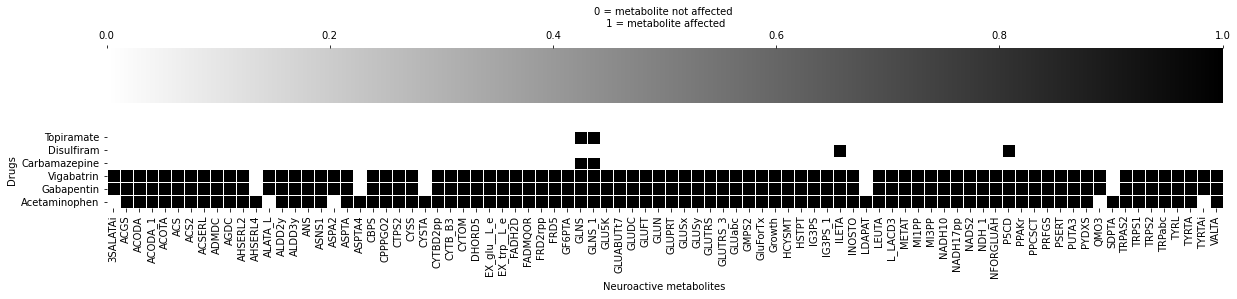

In [40]:
# plt.figure(figsize = (20,10))

# s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

# s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# # plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

## Neuroactive METABOLITES

In [ ]:
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
NeuroMetabDF=pd.read_excel('NeuroMetab.xlsx')
NeuroMetabList=NeuroMetabDF['BiGGIDnoM'].tolist()
# modelMetabs=[]
df = pd.DataFrame(columns=['NeuroactiveMetabolite'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
    ObjValue_before=Model.optimize().objective_value
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
        directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
        Model.optimize()
        fluxAfter=flux_variability_analysis(Model)
        fluxAfter=fluxAfter.round(0)
        fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
#         print('total number of reactions with changed fluxes', len(fluxesCompare))
        directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
#         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
        totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
#         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
        totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
        print(totalNeuroAffectedRxs)
        if totalNeuroAffectedRxs:
            for reaction in totalNeuroAffectedRxs:
                metabs=Model.reactions.get_by_id(reaction).metabolites
                metlist=[]
                for met in metabs:
                    metlist.append(met)
                    metlist
                    metlistids=[]
                for m in metlist:
                    metlistids.append(m.id)
                    metlistids
                for Metab in metlistids:
#                     if Metab in modelMetabs:
                    if Metab in NeuroMetabList:
                        row=[Metab, True]
                        drugData.append(row)
            DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveMetabolite', drugName.item()])
            print(DrugDF)
        else:
            DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

In [57]:
modelData=LB_data.copy()

In [ ]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveMetabolite', how='outer').fillna(False)
# df  

In [65]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub

In [66]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveMetabolite')
# noDub

In [67]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveMetabolite,glu__L_c,ac_c,ppa_c,amet_c,mqn8_c,mqn7_c,mqn6_c,glu__L_e,inost_c,trp__L_c,trp__L_e
Topiramate,1,0,0,0,0,0,0,0,0,0,0
Disulfiram,1,0,0,0,0,0,0,0,0,0,0
Carbamazepine,1,0,0,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,1
Gabapentin,1,1,1,1,1,1,1,1,1,1,1
Acetaminophen,1,1,1,1,1,1,1,1,1,1,1


In [72]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveMetabolite,ac_c,amet_c,glu__L_c,glu__L_e,inost_c,mqn6_c,mqn7_c,mqn8_c,ppa_c,trp__L_c,trp__L_e
Topiramate,0,0,1,0,0,0,0,0,0,0,0
Disulfiram,0,0,1,0,0,0,0,0,0,0,0
Carbamazepine,0,0,1,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,1
Gabapentin,1,1,1,1,1,1,1,1,1,1,1
Acetaminophen,1,1,1,1,1,1,1,1,1,1,1


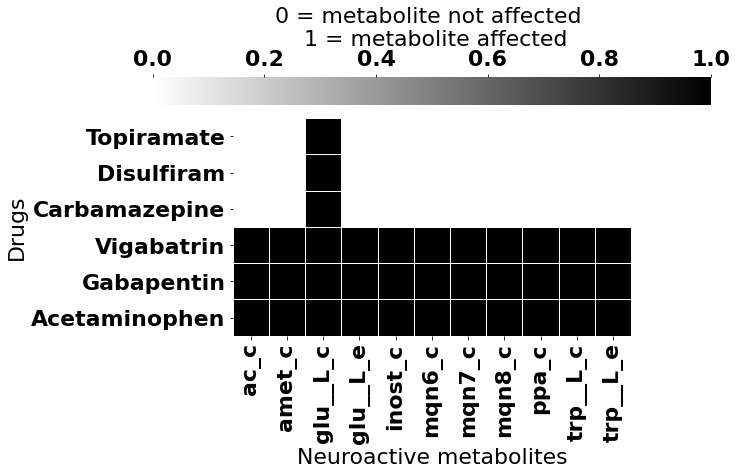

In [79]:
plt.figure(figsize = (10,5))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")